# Libraries

In [31]:
import numpy as np
from ase.io import read, write
from ase import Atoms
from typing import Dict, List, Optional, Tuple, Union, Literal
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from dataclasses import dataclass
import warnings
from pathlib import Path
from mace.calculators import MACECalculator
from nequip.ase import NequIPCalculator
import json

# Functions

In [65]:
@dataclass
class PlottingConfig:
    """Configuration for plot styling."""
    title_size: int = 22
    label_size: int = 18
    tick_size: int = 16
    legend_size: int = 16
    text_size: int = 16  # For metrics text box
    colorbar_size: int = 16

@dataclass
class AnalysisConfig:
    """Configuration for parity analysis."""
    properties: List[Literal['energy', 'forces', 'stress']] = None
    n_outliers: int = 0
    figsize: Tuple[int, int] = (10, 10)
    cmap: str = 'viridis'
    gridsize: int = 30
    save_plots: bool = True
    output_dir: Optional[str] = None
    reduced_energy: bool = False
    plotting: PlottingConfig = PlottingConfig()
    
    def __post_init__(self):
        if self.properties is None:
            self.properties = ['energy', 'forces', 'stress']
        if self.output_dir:
            Path(self.output_dir).mkdir(parents=True, exist_ok=True)
        if isinstance(self.plotting, dict):
            self.plotting = PlottingConfig(**self.plotting)

class ParityData:
    """Container for parity plot data with outlier handling."""
    def __init__(self, y_true: np.ndarray, y_pred: np.ndarray, metrics: Dict):
        self.y_true = y_true
        self.y_pred = y_pred
        self.metrics = metrics
        self.original_length = len(y_true)
        
    def remove_outliers(self, n_outliers: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Remove the n_outliers worst predictions based on absolute error.
        
        Args:
            n_outliers: Number of outliers to remove
            
        Returns:
            Tuple of cleaned (y_true, y_pred) arrays
        """
        if n_outliers == 0:
            return self.y_true, self.y_pred
            
        errors = np.abs(self.y_true - self.y_pred)
        sorted_indices = np.argsort(errors)
        keep_indices = sorted_indices[:-n_outliers] if n_outliers > 0 else sorted_indices
        
        return self.y_true[keep_indices], self.y_pred[keep_indices]
    
    def save(self, filepath: Path):
        """Save data to npz file."""
        np.savez(filepath,
                 y_true=self.y_true,
                 y_pred=self.y_pred,
                 metrics=np.array([json.dumps(self.metrics)], dtype=object),
                 original_length=self.original_length)
    
    @classmethod
    def load(cls, filepath: Path):
        """Load data from npz file."""
        data = np.load(filepath, allow_pickle=True)
        metrics = json.loads(data['metrics'][0])
        instance = cls(data['y_true'], data['y_pred'], metrics)
        instance.original_length = int(data['original_length'])
        return instance

@dataclass
class MultiGenConfig:
    """Configuration for multi-generation comparison plots."""
    base_size: float = 6.0  # Base size for each subplot square
    n_outliers: int = 0
    colorbar_position: str = 'right'  # 'right' or 'bottom'
    share_colorbar: bool = True
    plotting: PlottingConfig = PlottingConfig()
    
    def __post_init__(self):
        if isinstance(self.plotting, dict):
            self.plotting = PlottingConfig(**self.plotting)
    
    def get_figsize(self, n_generations: int) -> Tuple[float, float]:
        """
        Calculate figure size to maintain square subplots.
        
        Args:
            n_generations: Number of generations to plot
            
        Returns:
            Tuple of (width, height)
        """
        width = self.base_size * n_generations
        if self.colorbar_position == 'right':
            width += self.base_size * 0.2  # Add 20% of base_size for colorbar
        height = self.base_size
        return (width, height)

class MLCalculatorWrapper:
    """Wrapper for ML calculators to provide unified interface."""
    
    def __init__(self, calculator_type: str, **calc_kwargs):
        """
        Initialize ML calculator wrapper.
        
        Args:
            calculator_type: Either 'mace' or 'allegro'
            **calc_kwargs: Arguments to pass to calculator constructor
        """
        self.calculator_type = calculator_type.lower()
        
        if self.calculator_type == 'mace':
            self.calculator = MACECalculator(**calc_kwargs)
        elif self.calculator_type == 'allegro':
            self.calculator = NequIPCalculator.from_deployed_model(**calc_kwargs)
        else:
            raise ValueError(f"Unknown calculator type: {calculator_type}")
    
    def calculate(self, atoms: Atoms) -> None:
        """Calculate properties for given atomic structure."""
        atoms.calc = self.calculator
        # Trigger calculation of all properties
        atoms.get_potential_energy()
        atoms.get_forces()
        atoms.get_stress()

class ParityAnalysis:
    """Enhanced parity analysis with interactive features for notebooks."""
    
    def __init__(self, calculator_type: str, **calc_kwargs):
        """
        Initialize parity analysis.
        
        Args:
            calculator_type: Either 'mace' or 'allegro'
            **calc_kwargs: Arguments for calculator initialization
        """
        self.calculator = MLCalculatorWrapper(calculator_type, **calc_kwargs)
        self.results = {}
        self.current_config = None
        
    @staticmethod
    def remove_outliers(y_true: np.ndarray, y_pred: np.ndarray, n_outliers: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Remove the n_outliers worst predictions based on absolute error.
        
        Args:
            y_true: Ground truth values
            y_pred: Predicted values
            n_outliers: Number of outliers to remove
            
        Returns:
            Cleaned true and predicted arrays
        """
        if n_outliers == 0:
            return y_true, y_pred
            
        errors = np.abs(y_true - y_pred)
        sorted_indices = np.argsort(errors)
        keep_indices = sorted_indices[:-n_outliers] if n_outliers > 0 else sorted_indices
        
        return y_true[keep_indices], y_pred[keep_indices]

    def unnormalize_energy(self, atoms):
        
        cohesive_energies = {'V' : -8.9570740632,
                     'Ti' : -7.6933483733,
                     'Cr' :   -9.5135640945,
                     'W' : -12.9589697286,
                     'Zr' : -8.4379360614
        }       
        # get the number of each atom element
        elements = atoms.get_chemical_symbols()
        
        # calculate the number of each element in the elements list and make a dictionary
        element_count = {i: elements.count(i) for i in elements}

        # get the residual energy from the atoms object
        residual_energy = atoms.get_potential_energy()
        if residual_energy is None:
            print(f"No residual energy found for Atoms object")
            return None
        
        # calculate the total energy by adding back the cohesive energies
        total_energy = residual_energy + sum([element_count[i] * cohesive_energies[i] for i in element_count])
        
        #print(f'Atoms object has un-normalized total energy {total_energy}, residual energy {residual_energy}')
        
        return total_energy

    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Calculate statistical metrics between true and predicted values."""
        if len(y_true) == 0:
            return {
                'rmse': np.nan,
                'rel_rmse': np.nan,
                'mae': np.nan,
                'r2': np.nan,
                'n_points': 0
            }
        
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        # Calculate relative RMSE
        rel_rmse = rmse / np.std(y_true) * 100 if np.std(y_true) > 0 else np.nan
            
        return {
            'rmse': rmse,
            'rel_rmse': rel_rmse,
            'mae': mae,
            'r2': r2,
            'n_points': len(y_true)
        }

    def create_parity_plot(self,
                        y_true: np.ndarray,
                        y_pred: np.ndarray,
                        title: str,
                        xlabel: str,
                        ylabel: str,
                        metrics: Dict[str, float],
                        ax: Optional[plt.Axes] = None,
                        plot_type: str = 'hexbin',
                        scatter_kwargs: Optional[Dict] = None) -> Optional[Figure]:
        """
        Create parity plot with either hexbin or scatter visualization.
        
        Args:
            y_true: True values
            y_pred: Predicted values
            title: Plot title
            xlabel: X-axis label
            ylabel: Y-axis label
            metrics: Dictionary of metrics
            ax: Optional matplotlib axis
            plot_type: Either 'hexbin' or 'scatter'
            scatter_kwargs: Additional arguments for scatter plot
            
        Returns:
            Optional matplotlib Figure
        """
        def format_number(number: float) -> str:
            """
            Format number to be more readable.
            Uses decimals instead of scientific notation when appropriate.
            
            Args:
                number: Number to format
                
            Returns:
                Formatted string
            """
            abs_num = abs(number)
            if abs_num < 0.001 or abs_num >= 1000:
                return f"{number:.2e}"
            elif abs_num < 0.01:
                return f"{number:.5f}"
            elif abs_num < 0.1:
                return f"{number:.4f}"
            elif abs_num < 1:
                return f"{number:.3f}"
            elif abs_num < 10:
                return f"{number:.2f}"
            else:
                return f"{number:.1f}"
            
        if ax is None:
            fig, ax = plt.subplots(figsize=self.current_config.figsize)
        else:
            fig = None
            
        # Calculate plot limits
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        buffer = (max_val - min_val) * 0.1
        plot_limits = [min_val - buffer, max_val + buffer]
        
        # Default scatter plot arguments
        default_scatter_kwargs = {
            'alpha': 0.5,
            's': 20,
            'c': 'blue',
            'marker': 'o'
        }
        
        if scatter_kwargs:
            default_scatter_kwargs.update(scatter_kwargs)
        
        # Create plot based on type
        if plot_type == 'hexbin':
            hb = ax.hexbin(y_true, y_pred,
                        gridsize=self.current_config.gridsize,
                        cmap=self.current_config.cmap,
                        extent=[*plot_limits, *plot_limits],
                        bins='log')
            
            # Add colorbar for hexbin
            cb = plt.colorbar(hb, ax=ax)
            cb.set_label('log10(N)', size=self.current_config.plotting.colorbar_size)
            cb.ax.tick_params(labelsize=self.current_config.plotting.tick_size)
        
        else:  # scatter plot
            ax.scatter(y_true, y_pred, **default_scatter_kwargs)
        
        # Add parity line
        ax.plot(plot_limits, plot_limits, 'r--', alpha=0.5)
        
        # Set labels and title with specified font sizes
        ax.set_xlabel(xlabel, size=self.current_config.plotting.label_size)
        ax.set_ylabel(ylabel, size=self.current_config.plotting.label_size)
        ax.set_title(title, size=self.current_config.plotting.title_size)
        ax.tick_params(labelsize=self.current_config.plotting.tick_size)
        
        # Add metrics text with decimal formatting
        metrics_text = (
            f"RMSE: {format_number(metrics['rmse'])}\n"
            f"Rel. RMSE: {format_number(metrics['rel_rmse'])}%\n"
            f"MAE: {format_number(metrics['mae'])}\n"
            f"R²: {format_number(metrics['r2'])}\n"
            f"N points: {metrics['n_points']}"
        )
        ax.text(0.05, 0.95, metrics_text,
                transform=ax.transAxes,
                verticalalignment='top',
                fontsize=self.current_config.plotting.text_size,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_aspect('equal')
        ax.set_xlim(plot_limits)
        ax.set_ylim(plot_limits)
        
        return fig
    
    def analyze(self,
                atoms_list: List[Atoms],
                config: Optional[AnalysisConfig] = None) -> Dict:
        """
        Perform parity analysis on atomic structures.
        
        Args:
            atoms_list: List of atomic structures
            config: Analysis configuration
            
        Returns:
            Dictionary containing metrics for each analyzed property
        """
        self.current_config = config or AnalysisConfig()
        
        # Initialize data collection
        data = {
            'energy': {'ref': [], 'pred': []},
            'forces': {'ref': [], 'pred': []},
            'stress': {'ref': [], 'pred': []}
        }
        
        # Collect data
        for i,atoms in enumerate(atoms_list):
            if i % 100 == 0:
                print(f"Analyzing structure {i+1}/{len(atoms_list)}")

            # Calculate predictions
            self.calculator.calculate(atoms)
            if i == 5:
                print(f"Energy of prediction = {atoms.get_potential_energy()}")
           
            # Energy
            if 'REF_energy' in atoms.info:
                data['energy']['ref'].append(atoms.info['REF_energy']/len(atoms))
                if self.current_config.reduced_energy:
                    energy = self.unnormalize_energy(atoms)/len(atoms)
                else:
                    energy = atoms.get_potential_energy()/len(atoms)
                data['energy']['pred'].append(energy)
                
            # Forces
            if 'REF_force' in atoms.arrays:
                data['forces']['ref'].extend(atoms.arrays['REF_force'].flatten())
                data['forces']['pred'].extend(atoms.get_forces().flatten())
                
            # Stress
            if 'REF_stress' in atoms.info:
                data['stress']['ref'].extend(atoms.info['REF_stress'])
                data['stress']['pred'].extend(atoms.get_stress(voigt=False).flatten())
        
        # Convert to arrays
        for prop in data:
            data[prop]['ref'] = np.array(data[prop]['ref'])
            data[prop]['pred'] = np.array(data[prop]['pred'])
        
        # Analyze selected properties
        self.results = {}
        property_labels = {
            'energy': ('Energy Parity Plot', 'Reference Energy (eV)', 'Predicted Energy (eV)'),
            'forces': ('Forces Parity Plot', 'Reference Forces (eV/Å)', 'Predicted Forces (eV/Å)'),
            'stress': ('Stress Parity Plot', 'Reference Stress (GPa)', 'Predicted Stress (GPa)')
        }
        self.parity_data = {}  # Store data for each property
        
        for prop in self.current_config.properties:
            if len(data[prop]['ref']) == 0:
                warnings.warn(f"No reference data found for {prop}")
                continue
                
            # Remove outliers
            y_true, y_pred = self.remove_outliers(
                data[prop]['ref'],
                data[prop]['pred'],
                self.current_config.n_outliers
            )
            
            # Calculate metrics
            self.results[prop] = self.calculate_metrics(y_true, y_pred)
            
            # Store data for later plotting
            self.parity_data[prop] = ParityData(y_true, y_pred, self.results[prop])
            
            # Save data if output directory specified
            if self.current_config.output_dir:
                data_path = Path(self.current_config.output_dir) / f'{prop}_data.npz'
                self.parity_data[prop].save(data_path)
            
            # Create and save plot
            fig = self.create_parity_plot(
                y_true, y_pred,
                *property_labels[prop],
                self.results[prop]
            )
            
            if self.current_config.save_plots and self.current_config.output_dir:
                fig.savefig(
                    Path(self.current_config.output_dir) / f'{prop}_parity.png',
                    dpi=300,
                    bbox_inches='tight'
                )
            plt.close(fig)
        
        return self.results
    
    @staticmethod
    def create_generation_comparison(
        data_paths: List[str],
        property_name: str,
        config: Optional[MultiGenConfig] = None,
        generation_labels: Optional[List[str]] = None,
        plot_type: str = 'hexbin',
        scatter_kwargs: Optional[Dict] = None
    ) -> Figure:
        """
        Create multi-generation comparison plot with shared colorbar.
        
        Args:
            data_paths: List of paths to generation data files
            property_name: Property to plot ('energy', 'forces', or 'stress')
            config: Configuration for multi-generation plotting
            generation_labels: Optional list of labels for each generation
            plot_type: Type of plot ('hexbin' or 'scatter')
            scatter_kwargs: Optional kwargs for scatter plots
        """
        if config is None:
            config = MultiGenConfig()
        
        if generation_labels is None:
            generation_labels = [f"Generation {i}" for i in range(len(data_paths))]

        # Calculate figure size
        figsize = config.get_figsize(len(data_paths))
        
        # Create figure with gridspec
        fig = plt.figure(figsize=figsize)
        if plot_type == 'hexbin':
            gs = plt.GridSpec(1, len(data_paths) + 1, 
                            width_ratios=[1]*len(data_paths) + [0.2],
                            figure=fig)
        else:
            gs = plt.GridSpec(1, len(data_paths), figure=fig)
        
        # Create axes
        axes = []
        for i in range(len(data_paths)):
            ax = fig.add_subplot(gs[0, i])
            ax.set_aspect('equal')
            axes.append(ax)
        
        # Load and process data
        all_data = []
        for path in data_paths:
            data = ParityData.load(Path(path))
            if config.n_outliers > 0:
                y_true, y_pred = data.remove_outliers(config.n_outliers)
                data.y_true, data.y_pred = y_true, y_pred
                data.metrics = ParityAnalysis.calculate_metrics(y_true, y_pred)
            all_data.append(data)
        
        # Get global limits
        global_min = min(min(data.y_true.min(), data.y_pred.min()) for data in all_data)
        global_max = max(max(data.y_true.max(), data.y_pred.max()) for data in all_data)
        buffer = (global_max - global_min) * 0.1
        plot_limits = [global_min - buffer, global_max + buffer]
        
        # Property labels
        labels = {
            'energy': ('Energy Parity Plot', 'Reference Energy (eV/atom)', 'Predicted Energy (eV/atom)'),
            'forces': ('Forces Parity Plot', 'Reference Forces (eV/Å)', 'Predicted Forces (eV/Å)'),
            'stress': ('Stress Parity Plot', 'Reference Stress (GPa)', 'Predicted Stress (GPa)')
        }
        
        # Default scatter settings
        default_scatter_kwargs = {
            'alpha': 0.3,
            's': 15,
            'c': 'blue',
            'marker': '.'
        }
        if scatter_kwargs:
            default_scatter_kwargs.update(scatter_kwargs)
        
        # Create plots and get colorbar data if needed
        hexbin_data = []
        max_count = 0
        
        for i, (data, ax) in enumerate(zip(all_data, axes)):
            if plot_type == 'hexbin':
                hb = ax.hexbin(data.y_true, data.y_pred,
                            gridsize=30,
                            cmap='viridis',
                            extent=[*plot_limits, *plot_limits],
                            bins='log')
                hexbin_data.append(hb)
                max_count = max(max_count, np.max(hb.get_array()))
            else:  # scatter
                ax.scatter(data.y_true, data.y_pred, **default_scatter_kwargs)
            
            # Add parity line and labels
            ax.plot(plot_limits, plot_limits, 'r--', alpha=0.5)
            ax.set_title(generation_labels[i], size=config.plotting.title_size)
            if i == 0:
                ax.set_ylabel(labels[property_name][2], size=config.plotting.label_size)
            ax.set_xlabel(labels[property_name][1], size=config.plotting.label_size)
            ax.tick_params(labelsize=config.plotting.tick_size)
            
            # Add metrics
            metrics_text = (
                f"RMSE: {format_number(data.metrics['rmse'])}\n"
                f"Rel. RMSE: {format_number(data.metrics['rel_rmse'])}%\n"
                f"MAE: {format_number(data.metrics['mae'])}\n"
                f"R²: {format_number(data.metrics['r2'])}\n"
                f"N points: {data.metrics['n_points']}"
            )
            ax.text(0.05, 0.95, metrics_text,
                    transform=ax.transAxes,
                    verticalalignment='top',
                    fontsize=config.plotting.text_size,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_xlim(plot_limits)
            ax.set_ylim(plot_limits)
        
        # Add colorbar for hexbin plots
        if plot_type == 'hexbin':
            for hb in hexbin_data:
                hb.set_clim(0, max_count)
            
            cax = fig.add_subplot(gs[0, -1])
            cb = plt.colorbar(hexbin_data[0], cax=cax)
            cb.ax.set_ylabel('log10(N)', size=config.plotting.colorbar_size)
            cb.ax.tick_params(labelsize=config.plotting.tick_size)
        
        plt.tight_layout()
        return fig

    @staticmethod
    def _create_generation_comparison(
        data_paths: List[str],
        property_name: str,
        config: Optional[MultiGenConfig] = None,
        generation_labels: Optional[List[str]] = None
    ) -> Figure:
        """
        Create multi-generation comparison plot with shared colorbar.
        
        Args:
            data_paths: List of paths to generation data files
            property_name: Property to plot ('energy', 'forces', or 'stress')
            config: Configuration for multi-generation plotting
            generation_labels: Optional list of labels for each generation
            
        Returns:
            matplotlib Figure
        """
        if config is None:
            config = MultiGenConfig()
        
        if generation_labels is None:
            generation_labels = [f"Generation {i}" for i in range(len(data_paths))]

        # Calculate figure size based on number of generations
        figsize = config.get_figsize(len(data_paths))
        
        # Create figure with gridspec for colorbar
        fig = plt.figure(figsize=figsize)
        
        # Setup GridSpec based on colorbar position
        if config.colorbar_position == 'right':
            gs = plt.GridSpec(1, len(data_paths) + 1, 
                            width_ratios=[1]*len(data_paths) + [0.2],
                            figure=fig)
        else:  # bottom
            gs = plt.GridSpec(2, len(data_paths), 
                            height_ratios=[1, 0.1],
                            figure=fig)
        
        # Create subplot axes
        axes = []
        for i in range(len(data_paths)):
            ax = fig.add_subplot(gs[0, i])
            ax.set_aspect('equal')  # Make plots square
            axes.append(ax)
        
        # Load and process all data
        all_data = []
        print("\nLoading and processing data...")
        for path in data_paths:
            try:
                data = ParityData.load(Path(path))
                if config.n_outliers > 0:
                    y_true, y_pred = data.remove_outliers(config.n_outliers)
                    data.y_true, data.y_pred = y_true, y_pred
                    data.metrics = ParityAnalysis.calculate_metrics(y_true, y_pred)
                all_data.append(data)
            except Exception as e:
                print(f"Error loading {path}: {str(e)}")
                return None
        
        # Calculate global limits for consistent scaling
        print("Calculating plot limits...")
        global_min = min(min(data.y_true.min(), data.y_pred.min()) for data in all_data)
        global_max = max(max(data.y_true.max(), data.y_pred.max()) for data in all_data)
        buffer = (global_max - global_min) * 0.1
        plot_limits = [global_min - buffer, global_max + buffer]
        
        # Property labels
        labels = {
            'energy': ('Energy Parity Plot', 'Reference Energy (eV/atom)', 'Predicted Energy (eV/atom)'),
            'forces': ('Forces Parity Plot', 'Reference Forces (eV/Å)', 'Predicted Forces (eV/Å)'),
            'stress': ('Stress Parity Plot', 'Reference Stress (GPa)', 'Predicted Stress (GPa)')
        }
        
        # Create hexbin plots
        print("Creating hexbin plots...")
        hexbin_data = []
        counts = []
        
        for i, (data, ax) in enumerate(zip(all_data, axes)):
            hb = ax.hexbin(data.y_true, data.y_pred,
                        gridsize=30,
                        cmap='viridis',
                        extent=[*plot_limits, *plot_limits],
                        bins='log',
                        mincnt=1)  # Ensure minimum count of 1
            hexbin_data.append(hb)
            # Get non-zero counts
            counts_array = hb.get_array()
            counts_array = counts_array[counts_array > 0]  # Only consider non-zero counts
            if len(counts_array) > 0:
                counts.extend(counts_array)
        
        # Calculate valid min/max for colorbar
        if counts:
            vmin = np.min(counts)
            vmax = np.max(counts)
        else:
            vmin = 1
            vmax = 10
        
        # Update all hexbin plots with consistent color scaling
        print("Normalizing plots and adding labels...")
        for i, (data, ax, hb) in enumerate(zip(all_data, axes, hexbin_data)):
            hb.set_clim(vmin, vmax)
            
            # Add parity line
            ax.plot(plot_limits, plot_limits, 'r--', alpha=0.5)
            
            # Set labels and title
            ax.set_title(generation_labels[i], size=config.plotting.title_size)
            if i == 0:  # Only leftmost plot gets y-label
                ax.set_ylabel(labels[property_name][2], size=config.plotting.label_size)
            ax.set_xlabel(labels[property_name][1], size=config.plotting.label_size)
            
            # Set tick parameters
            ax.tick_params(labelsize=config.plotting.tick_size)
            
            # Add metrics text
            metrics_text = (
                f"RMSE: {1000*data.metrics['rmse']:.2e}\n"
                f"Rel. RMSE: {data.metrics['rel_rmse']:.1f}%\n"
                f"MAE: {1000*data.metrics['mae']:.2e}\n"
                f"R²: {data.metrics['r2']:.3f}\n"
                f"N points: {data.metrics['n_points']}"
            )
            ax.text(0.05, 0.95, metrics_text,
                    transform=ax.transAxes,
                    verticalalignment='top',
                    fontsize=config.plotting.text_size,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Set consistent limits
            ax.set_xlim(plot_limits)
            ax.set_ylim(plot_limits)
        
        # Add unified colorbar
        print("Adding colorbar...")
        norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
        if config.colorbar_position == 'right':
            cax = fig.add_subplot(gs[0, -1])
            cb = plt.colorbar(hexbin_data[0], cax=cax, norm=norm)
            cb.ax.set_ylabel('log10(N)', size=config.plotting.colorbar_size)
        else:
            cax = fig.add_subplot(gs[1, :])
            cb = plt.colorbar(hexbin_data[0], cax=cax, orientation='horizontal', norm=norm)
            cb.ax.set_xlabel('log10(N)', size=config.plotting.colorbar_size)
        
        cb.ax.tick_params(labelsize=config.plotting.tick_size)
        
        # Adjust layout
        plt.tight_layout()
        
        print("Plot generation complete!")
        return fig
    
    def print_summary(self):
        """Print summary of analysis results."""
        if not self.results:
            print("No analysis results available. Run analyze() first.")
            return
            
        print("Analysis Summary:")
        print("-" * 50)
        for prop, metrics in self.results.items():
            print(f"\n{prop.capitalize()}:")
            print(f"  RMSE: {metrics['rmse']:.2e}")
            print(f"  Rel. RMSE: {metrics['rel_rmse']:.1f}%")
            print(f"  MAE: {metrics['mae']:.2e}")
            print(f"  R²: {metrics['r2']:.3f}")
            print(f"  Points analyzed: {metrics['n_points']}")

## code for checking if we already ran things

In [66]:
def check_existing_analysis(base_dir: Path, generation: int) -> bool:
    """
    Check if analysis data already exists for a given generation.
    
    Args:
        base_dir: Base directory for analysis output
        generation: Generation number to check
        
    Returns:
        bool: True if data exists and is valid
    """
    gen_dir = base_dir / f'gen_{generation}_analysis'
    data_file = gen_dir / 'forces_data.npz'
    
    if not data_file.exists():
        return False
        
    # Try loading the data to ensure it's valid
    try:
        data = ParityData.load(data_file)
        return True
    except Exception as e:
        print(f"Found corrupted data for generation {generation}: {str(e)}")
        return False


def create_comparison_plot(base_dir: Path, force_replot: bool = False):
    """
    Create or recreate the comparison plot.
    
    Args:
        base_dir: Base directory containing generation data
        force_replot: If True, recreate plot even if it exists
    """
    output_file = base_dir / 'force_evolution.png'
    if output_file.exists() and not force_replot:
        print("\nPlot already exists. Set force_replot=True to regenerate.")
        return
        
    print("\nCreating multi-generation comparison plot...")
    
    # Setup generation labels
    generation_labels = [f"Generation {i}" for i in range(5)]
    
    # Configure multi-generation plot
    config = MultiGenConfig(
        base_size=8.0,
        n_outliers=10,
        colorbar_position='right',
        plotting=PlottingConfig(
            title_size=22,
            label_size=18,
            tick_size=16,
            text_size=16,
            colorbar_size=16
        )
    )
    
    # Paths to generation data
    data_paths = [
        str(base_dir / f'gen_{i}_analysis/forces_data.npz')
        for i in range(5)
    ]
    
    # Verify all data exists
    missing_data = [i for i, path in enumerate(data_paths) 
                   if not Path(path).exists()]
    
    if missing_data:
        print(f"Warning: Missing data for generations: {missing_data}")
        return
        
    # Create and save comparison plot
    fig = ParityAnalysis.create_generation_comparison(
        data_paths=data_paths,
        property_name='forces',
        config=config,
        generation_labels=generation_labels
    )
    
    # Save plot
    fig.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\nSaved comparison plot to {output_file}")

# Run the Code

In [35]:
# Import the module
#from parity_analysis import ParityAnalysis, AnalysisConfig

# Initialize analyzer with MACE calculator
analyzer = ParityAnalysis(
    calculator_type='mace',
    model_paths='../Models/zr-w-v-ti-cr/gen_1_2024-11-09/',
    device='cpu',
    default_dtype='float32'
)

# Load test structures
test_structures = read("../data/zr-w-v-ti-cr/gen_4_2024-11-15/gen_4_2024-11-14_test.xyz", index=':')

# Create configuration
config = AnalysisConfig(
    properties=['energy', 'forces','stress'],  # Only analyze energy and forces
    n_outliers=5,                    # Remove 5 worst predictions
    figsize=(12, 12),               # Larger plots
    save_plots=True,
    output_dir='parity_analysis/gen_4_2024-11-15',
    reduced_energy = False 
)

# Run analysis
results = analyzer.analyze(test_structures, config)

# Print summary
analyzer.print_summary()

Analyzing structure 1/1860
Energy of prediction = 4.371420860290527


KeyboardInterrupt: 

# Multi Generation Plot

In [69]:
import os 
from pathlib import Path
from ase.io import read
import matplotlib.pyplot as plt
import warnings
import matplotlib 
import matplotlib.colors

def create_property_plot(base_dir: Path, property_name: str, force_replot: bool = False, plot_types: List[str] = ['hexbin', 'scatter']):
    """
    Create comparison plot for a specific property with multiple visualization types.
    
    Args:
        base_dir: Base directory containing generation data
        property_name: Name of property to plot ('energy', 'forces', or 'stress')
        force_replot: If True, recreate plot even if it exists
        plot_types: List of plot types to create ('hexbin' and/or 'scatter')
    """
    for plot_type in plot_types:
        output_file = base_dir / f'{property_name}_evolution_{plot_type}.png'
        if output_file.exists() and not force_replot:
            print(f"\n{property_name.capitalize()} {plot_type} plot already exists. Set force_replot=True to regenerate.")
            continue

        print(f"\nCreating {property_name} {plot_type} comparison plot...")
        
        # Setup generation labels
        generation_labels = [f"Generation {i}" for i in range(5)]
        
        # Configure multi-generation plot
        config = MultiGenConfig(
            base_size=8.0,
            n_outliers=10,
            colorbar_position='right',
            plotting=PlottingConfig(
                title_size=22,
                label_size=18,
                tick_size=16,
                text_size=16,
                colorbar_size=16
            )
        )
        
        # Paths to generation data
        data_paths = [
            str(base_dir / f'gen_{i}_analysis/{property_name}_data.npz')
            for i in range(5)
        ]
        
        # Verify all data exists
        missing_data = [i for i, path in enumerate(data_paths) 
                       if not Path(path).exists()]
        
        if missing_data:
            print(f"Warning: Missing {property_name} data for generations: {missing_data}")
        else:
            # Scatter plot specific settings
            scatter_kwargs = None
            if plot_type == 'scatter':
                scatter_kwargs = {
                    'alpha': 0.3,
                    's': 15,
                    'c': 'blue',
                    'marker': '.'
                }
            
            # Create and save comparison plot
            fig = ParityAnalysis.create_generation_comparison(
                data_paths=data_paths,
                property_name=property_name,
                config=config,
                generation_labels=generation_labels,
                plot_type=plot_type,
                scatter_kwargs=scatter_kwargs
            )
            
            # Save plot
            fig.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"Saved {property_name} {plot_type} plot to {output_file}")



# Load structures
structures = read('../data/zr-w-v-ti-cr/gen_4_2024-11-15/gen_4_2024-11-14_test.xyz', index=':100')

# Model paths
models = [
    '../Models/zr-w-v-ti-cr/gen_0_2024-11-06/gen_0_model_0-11-06-fixedtest_stagetwo_compiled.model',
    '../Models/zr-w-v-ti-cr/gen_1_2024-11-09/gen_1_model_3-11-09_stagetwo_compiled.model',
    '../Models/zr-w-v-ti-cr/gen_2_2024-11-11/gen_2_model_0-11-11_stagetwo_compiled.model',
    '../Models/zr-w-v-ti-cr/gen_3_2024-11-13/gen_3_model_0-11-13_stagetwo_compiled.model',
    '../Models/zr-w-v-ti-cr/gen_4_2024-11-15/gen_4_model_0-11-14_b4_stagetwo_compiled.model'
]

models = [
    '../Models/zr-w-v-ti-cr/gen_4_2024-11-24_Allegro/gen_4_2024-11-24_model_0_r6_nl1_l0.pth',
    '../Models/zr-w-v-ti-cr/gen_4_2024-11-24_Allegro/gen_4_2024-11-24_model_0_r7_nl1_l1.pth',
    '../Models/zr-w-v-ti-cr/gen_4_2024-11-24_Allegro/gen_4_2024-11-24_model_0_r8_nl2_l1.pth'
]

# Base output directory
base_output_dir = Path('parity_analysis/test')
base_output_dir.mkdir(exist_ok=True)

# Properties to analyze
properties = ['energy', 'forces', 'stress']

# Check and analyze each generation
for gen in range(3):
    """
    skip_gen = True
    for prop in properties:
        data_file = base_output_dir / f'gen_{gen}_analysis/{prop}_data.npz'
        if not data_file.exists():
            skip_gen = False
            break
    
    if skip_gen:
        print(f"\nSkipping Generation {gen} - analysis already exists")
        continue
        
    print(f"\nAnalyzing Generation {gen}")
    """
    
    # Configure analysis
    """
    analyzer = ParityAnalysis(
        'mace',
        model_paths=models[gen],
        device='cpu',
        default_dtype='float32'
    )
    """
    species = {'V': 'V', 'Cr': 'Cr', 'Ti': 'Ti', 'W': 'W', 'Zr': 'Zr'}
    analyzer = ParityAnalysis(
        'allegro',
        model_path=models[gen],
        species_to_type_name=species,
        device='cpu',
        default_dtype='float32'
    )
    
    config = AnalysisConfig(
        properties=properties,  # Analyze all properties
        plotting=PlottingConfig(
            title_size=22,
            label_size=18,
            tick_size=16
        ),
        output_dir=str(base_output_dir / f'gen_{gen}_analysis'),
        #reduced_energy=(gen == 0)  # Only true for gen 0
    )
    
    # Run analysis
    analyzer.analyze(structures, config)

# Create both types of plots for each property
properties = ['energy', 'forces', 'stress']
for property_name in properties:
    create_property_plot(
        base_output_dir, 
        property_name,
        force_replot=True,  # Force recreate plots
        plot_types=['scatter']  # Create both types
    )
    
# Create plots for each property
#for property_name in properties:
    #create_property_plot(base_output_dir, property_name)

/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:95: UserWarning: Do NOT manually set PYTORCH_JIT_USE_NNC_NOT_NVFUSER=0 unless you know exactly what you're doing!
  warnings.warn(


Analyzing structure 1/100
Energy of prediction = -1116.982177734375


/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:95: UserWarning: Do NOT manually set PYTORCH_JIT_USE_NNC_NOT_NVFUSER=0 unless you know exactly what you're doing!
  warnings.warn(


Analyzing structure 1/100
Energy of prediction = -1117.2777099609375


/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:95: UserWarning: Do NOT manually set PYTORCH_JIT_USE_NNC_NOT_NVFUSER=0 unless you know exactly what you're doing!
  warnings.warn(


Analyzing structure 1/100
Energy of prediction = -1117.28466796875

Creating energy scatter comparison plot...

Creating forces scatter comparison plot...

Creating stress scatter comparison plot...


In [5]:
def create_scatter_parity(npz_file: str, output_file: str = None, figsize: tuple = (10, 10)):
    """
    Create a simple scatter parity plot from saved npz data.
    
    Args:
        npz_file: Path to npz file containing y_true, y_pred, and metrics
        output_file: Optional path to save the plot
        figsize: Figure size as (width, height)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import json
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    
    # Load data
    data = np.load(npz_file, allow_pickle=True)
    y_true = data['y_true']
    y_pred = data['y_pred']
    metrics = json.loads(data['metrics'][0])
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate plot limits
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    buffer = (max_val - min_val) * 0.1
    plot_limits = [min_val - buffer, max_val + buffer]
    
    # Create scatter plot
    ax.scatter(y_true, y_pred, alpha=0.3, s=30, c='#687a3e', marker='.')
    
    # Add parity line
    ax.plot(plot_limits, plot_limits, linestyle='--', color='#f8a27f')
    
    # Set labels and title with larger font sizes
    ax.set_xlabel('Reference', fontsize=18)
    ax.set_ylabel('Predicted', fontsize=18)
    ax.set_title('Parity Plot', fontsize=22)
    ax.tick_params(labelsize=16)
    
    # Format metrics for text
    def format_num(x):
        if abs(x) < 0.01 or abs(x) >= 1000:
            return f"{x:.2e}"
        else:
            return f"{x:.3f}"
    
    # Add metrics text
    metrics_text = (
        f"RMSE: {format_num(metrics['rmse'])}\n"
        f"Rel. RMSE: {format_num(metrics['rel_rmse'])}%\n"
        f"MAE: {format_num(metrics['mae'])}\n"
        f"R²: {format_num(metrics['r2'])}\n"
        f"N points: {metrics['n_points']}"
    )
    ax.text(0.05, 0.95, metrics_text,
            transform=ax.transAxes,
            verticalalignment='top',
            fontsize=16,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Set aspect ratio and limits
    ax.set_aspect('equal')
    ax.set_xlim(plot_limits)
    ax.set_ylim(plot_limits)
    
    plt.tight_layout()
    
    # Save if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig, ax

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Parity Plot'}, xlabel='Reference', ylabel='Predicted'>)

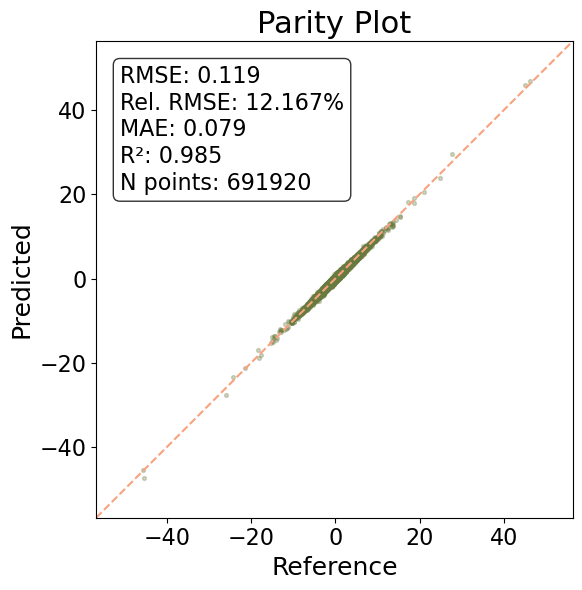

In [14]:
# Example usage:
create_scatter_parity('parity_analysis/allegro_gen_4_2024-11-24/gen_2_analysis/forces_data.npz', 'test_allegro_forces_scatter.png',figsize=(6,6))